In [1]:
from ase_interface import ANIENS
from ase_interface import ensemblemolecule

import aniensemblestats as aes
import pyaniasetools as aat

import pyanitools as pyt

import numpy as np
import ase

#from ase.neb import NEBtools
from ase.io import read, write

import matplotlib
import matplotlib as mpl
from matplotlib import gridspec 
import matplotlib.pyplot as plt

import hdnntools as hdt

from scipy import stats

import os

van Der Waals correction will be unavailable. Please install ased3


/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#ntdir = '/home/jsmith48/scratch/TZData/train_L2T1E-6_ba/'
#ntdir = '/home/jsmith48/scratch/TZData_force/train_msecost_1.0_0.25/'
ntdir1 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/dft_DZ_retrain/retrain_dft_f01/'
cns1 = ntdir1 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae1 = ntdir1 + 'sae_linfit.dat'
nnf1 = ntdir1 + 'train'
Nn1 = 5

ntdir2 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/ful_train/'
cns2 = ntdir2 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae2 = ntdir2 + 'sae_linfit.dat'
nnf2 = ntdir2 + 'train'
Nn2 = 5

ntdir3 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/ANI-1x_DFTDZ/'
cns3 = ntdir3 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae3 = ntdir3 + 'sae_linfit.dat'
nnf3 = ntdir3 + 'train'
Nn3 = 5

ts = '/home/jsmith48/scratch/ccsd_extrapolation/h5files_holdout_split/testset/r10_ccsd_test.h5'

dftdir = '/home/jsmith48/scratch/ccsd_extrapolation/h5files_holdout_split/testset/xyz/'

In [3]:
dftfiles = [f for f in os.listdir(dftdir) if f[-4:] == '.dat']
dftdata = dict()
for f in dftfiles:
    data = hdt.readncdatall(dftdir+f)
    dftdata.update({f.rsplit('.',1)[0]:data})
    

In [4]:
# Set NC
aens_1 = aat.anicrossvalidationconformer(cns1, sae1, nnf1, Nn1, 1)
aens_2 = aat.anicrossvalidationconformer(cns2, sae2, nnf2, Nn2, 1)
aens_3 = aat.anicrossvalidationconformer(cns3, sae3, nnf3, Nn3, 1)

In [5]:
adl = pyt.anidataloader(ts)

In [6]:
Eal=[]
dEal=[]
Emin=[]

Na = []
for i,data in enumerate(adl):
    #if i  == 100:
    #    break
    if data['path'][1:] in dftdata:
        
        # Get reference data
        X = np.array(data['coordinates'],dtype=np.float32)
        S = data['species']
        E = hdt.hatokcal*data['energies']
        Na.append(len(S))
        
        # Compute SAE lin fit
        Esae= hdt.hatokcal*hdt.compute_sae(file=sae1,spc=S)
        Esae_dft= hdt.hatokcal*hdt.compute_sae(file=sae3,spc=S)
        
        # Define Eref
        Eref = E-Esae
        
        # Define DFT comparison
        dft = dftdata[data['path'][1:]]
        Edft = hdt.hatokcal*dft['energies']-Esae_dft

        # Compute energies and forces
        Ea1_t,Fa1_t,Sa1 = aens_1.compute_energyandforce_conformations(X,S)
        Ea2_t,Fa2_t,Sa2 = aens_2.compute_energyandforce_conformations(X,S)
        Ea3_t,Fa3_t,Sa3 = aens_3.compute_energyandforce_conformations(X,S)

        idx = np.where(Sa1 < 500.0)
        
        print('Computing:',i,len(S),data['path'],idx[0].size)
        
        if idx[0].size != 0:

            # Define NN shifted energies
            Eal1 = Ea1_t[idx]-Esae
            Eal2 = Ea2_t[idx]-Esae
            Eal3 = Ea3_t[idx]-Esae_dft

            # Define NN E distmats
            dEal1 = hdt.calculatedmat(Ea1_t[idx])
            dEal2 = hdt.calculatedmat(Ea2_t[idx])
            dEal3 = hdt.calculatedmat(Ea3_t[idx])

            # Store E mins
            Emin.append(np.array([[Eref[idx].min(),Eal1.min(),Eal2.min(),Eal3.min(),Edft[idx].min()]]))

            # Store E and dE
            Eal.append(np.vstack([Eref[idx],Eal1,Eal2,Eal3,Edft[idx]]))
            dEal.append(np.vstack([hdt.calculatedmat(Eref[idx]),dEal1,dEal2,dEal3,hdt.calculatedmat(Edft[idx])]))
            #print(dEal[-1].shape)
        
Eal = np.hstack(Eal)
dEal = np.hstack(dEal)
#print(dEal.shape,dEal)
Na = np.array(Na)
Emin=np.vstack(Emin)

Computing: 0 16 /mol_10076 10
Computing: 1 17 /mol_1008 10
Computing: 2 20 /mol_10080 10
Computing: 3 23 /mol_10102 10
Computing: 4 24 /mol_10110 10
Computing: 5 22 /mol_10111 10
Computing: 6 22 /mol_10117 10
Computing: 7 21 /mol_10124 10
Computing: 8 20 /mol_10132 10
Computing: 9 21 /mol_10179 10
Computing: 10 22 /mol_10190 10
Computing: 11 20 /mol_10198 10
Computing: 12 19 /mol_10200 10
Computing: 13 20 /mol_10223 10
Computing: 14 18 /mol_10233 10
Computing: 15 25 /mol_10237 10
Computing: 16 17 /mol_10238 10
Computing: 17 21 /mol_10282 10
Computing: 18 23 /mol_10288 10
Computing: 19 21 /mol_10344 10
Computing: 20 25 /mol_10381 10
Computing: 21 26 /mol_10385 10
Computing: 22 23 /mol_1039 10
Computing: 23 20 /mol_10405 10
Computing: 24 20 /mol_10406 10
Computing: 25 21 /mol_10410 10
Computing: 26 21 /mol_10422 10
Computing: 27 17 /mol_10438 10
Computing: 28 18 /mol_1049 10
Computing: 29 16 /mol_1051 10
Computing: 30 16 /mol_1065 10
Computing: 31 21 /mol_10678 10
Computing: 32 18 /mol_1

Computing: 272 21 /mol_1541 10
Computing: 273 18 /mol_1542 10
Computing: 274 23 /mol_15433 10
Computing: 275 22 /mol_15444 10
Computing: 276 17 /mol_15445 10
Computing: 277 20 /mol_15446 10
Computing: 278 23 /mol_15448 10
Computing: 279 20 /mol_15450 10
Computing: 280 16 /mol_1549 10
Computing: 281 19 /mol_15527 10
Computing: 282 19 /mol_15589 10
Computing: 283 19 /mol_15608 10
Computing: 284 22 /mol_15632 10
Computing: 285 18 /mol_15656 10
Computing: 286 20 /mol_15659 10
Computing: 287 18 /mol_15690 10
Computing: 288 18 /mol_15726 10
Computing: 289 23 /mol_15738 10
Computing: 290 21 /mol_15744 10
Computing: 291 17 /mol_15778 10
Computing: 292 24 /mol_15797 10
Computing: 293 17 /mol_15798 10
Computing: 294 22 /mol_15806 10
Computing: 295 21 /mol_15816 10
Computing: 296 20 /mol_15818 10
Computing: 297 17 /mol_15832 10
Computing: 298 16 /mol_15835 10
Computing: 299 21 /mol_15837 10
Computing: 300 26 /mol_15844 10
Computing: 301 24 /mol_15851 10
Computing: 302 23 /mol_15853 10
Computing: 

Computing: 530 22 /mol_21010 10
Computing: 531 23 /mol_21041 10
Computing: 532 21 /mol_21063 10
Computing: 533 20 /mol_21070 10
Computing: 534 22 /mol_21078 10
Computing: 535 17 /mol_2109 10
Computing: 536 21 /mol_21091 10
Computing: 537 20 /mol_21120 10
Computing: 538 17 /mol_2114 10
Computing: 539 26 /mol_21161 10
Computing: 540 25 /mol_21169 10
Computing: 541 18 /mol_21181 10
Computing: 542 23 /mol_21182 10
Computing: 543 16 /mol_21241 10
Computing: 544 25 /mol_21270 10
Computing: 545 22 /mol_21304 10
Computing: 546 21 /mol_21341 10
Computing: 547 23 /mol_21354 10
Computing: 548 21 /mol_21355 10
Computing: 549 20 /mol_21371 10
Computing: 550 22 /mol_21384 10
Computing: 551 20 /mol_21386 10
Computing: 552 16 /mol_2145 10
Computing: 553 22 /mol_21459 10
Computing: 554 24 /mol_21479 10
Computing: 555 18 /mol_21493 10
Computing: 556 20 /mol_21514 10
Computing: 557 20 /mol_21517 10
Computing: 558 17 /mol_21670 10
Computing: 559 18 /mol_21694 10
Computing: 560 25 /mol_21720 10
Computing: 

Computing: 802 17 /mol_6443 10
Computing: 803 20 /mol_6446 10
Computing: 804 21 /mol_6457 10
Computing: 805 18 /mol_6475 10
Computing: 806 18 /mol_6478 10
Computing: 807 17 /mol_654 10
Computing: 808 19 /mol_6548 10
Computing: 809 19 /mol_6565 10
Computing: 810 21 /mol_6588 10
Computing: 811 21 /mol_6618 10
Computing: 812 25 /mol_6620 10
Computing: 813 19 /mol_6769 10
Computing: 814 17 /mol_679 10
Computing: 815 19 /mol_6804 10
Computing: 816 20 /mol_6863 10
Computing: 817 19 /mol_6926 10
Computing: 818 18 /mol_6938 10
Computing: 819 20 /mol_6962 10
Computing: 820 20 /mol_697 10
Computing: 821 24 /mol_6977 10
Computing: 822 24 /mol_6993 10
Computing: 823 16 /mol_700 10
Computing: 824 18 /mol_7006 10
Computing: 825 17 /mol_7024 10
Computing: 826 18 /mol_7028 10
Computing: 827 18 /mol_7032 10
Computing: 828 21 /mol_7034 10
Computing: 829 24 /mol_7037 10
Computing: 830 18 /mol_7042 10
Computing: 831 18 /mol_705 10
Computing: 832 16 /mol_7051 10
Computing: 833 22 /mol_7119 10
Computing: 83

In [7]:
#print(Eal1.shape,len(Edl))
print(Emin[:,0].min(),Emin[:,1].min(),Emin[:,2].min(),Emin[:,3].min())

-140.84035620605573 -141.18962526525138 -142.371500822308 -143.57443100924138


In [8]:
print('E error')
rms = hdt.calculaterootmeansqrerror(Eal[1,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[1,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[2,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[2,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[3,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[3,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[4,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[4,:],Eal[0,:])
print(mae,rms)

E error
0.919673727678071 1.3175669841438096
1.0232647079113042 1.3752781454606793
6.644517529566022 7.907931276575781
6.852029138147958 8.051270384387452


In [9]:
print('dE error')
rms = hdt.calculaterootmeansqrerror(dEal[1,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[1,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[2,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[2,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[3,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[3,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[4,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[4,:],dEal[0,:])
print(mae,rms)

dE error
0.6547972459107069 0.8718842430467371
0.88044968044771 1.1453816540941861
0.848131400924945 1.1302941385509282
0.4444078806404183 0.5649388324719895


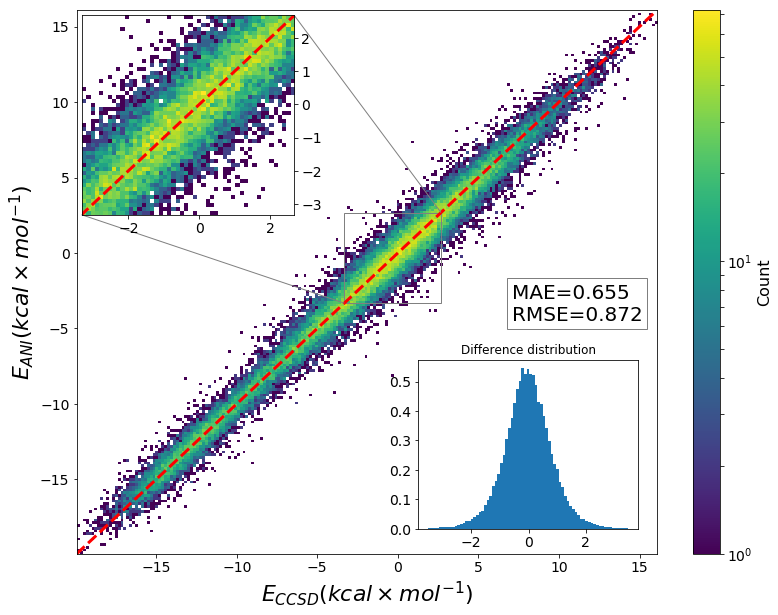

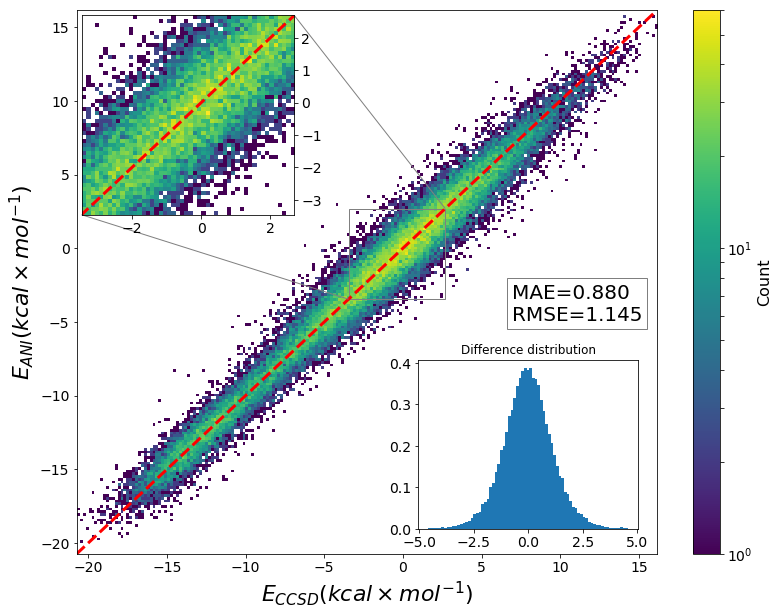

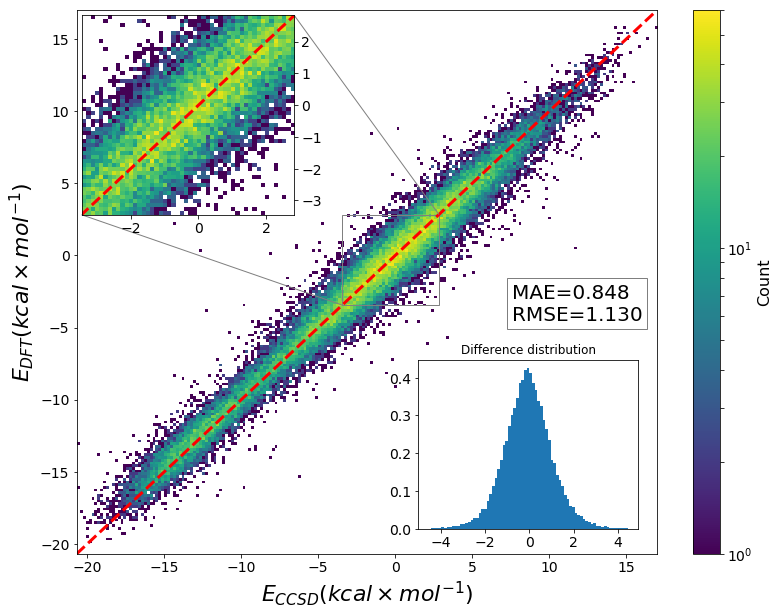

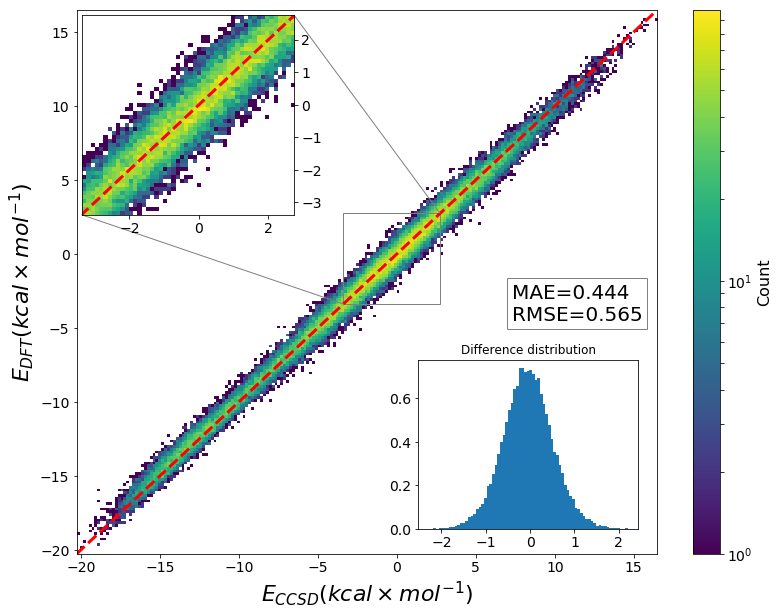

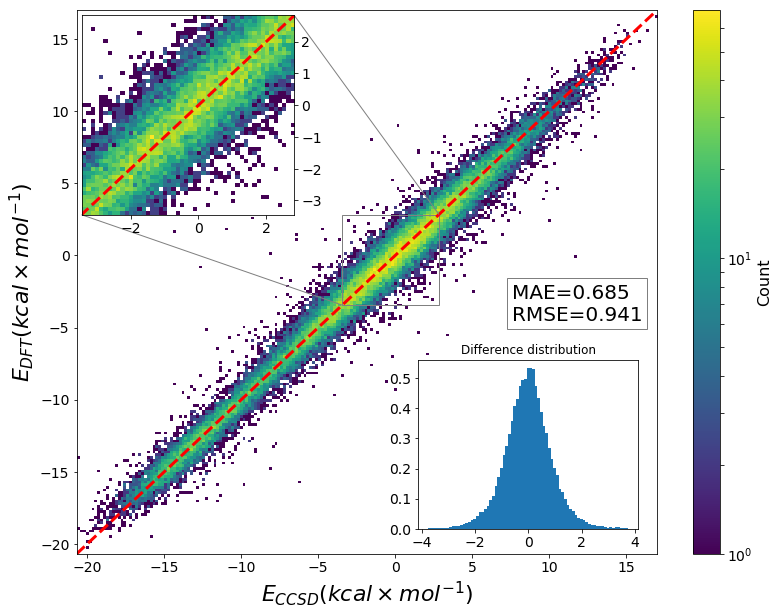

In [10]:
#dft_shift = Edl.mean()-Eal3.mean()

aes.plot_corr_dist(dEal[1,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{ANI} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[2,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{ANI} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[3,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[4,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[3,:],dEal[4,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')

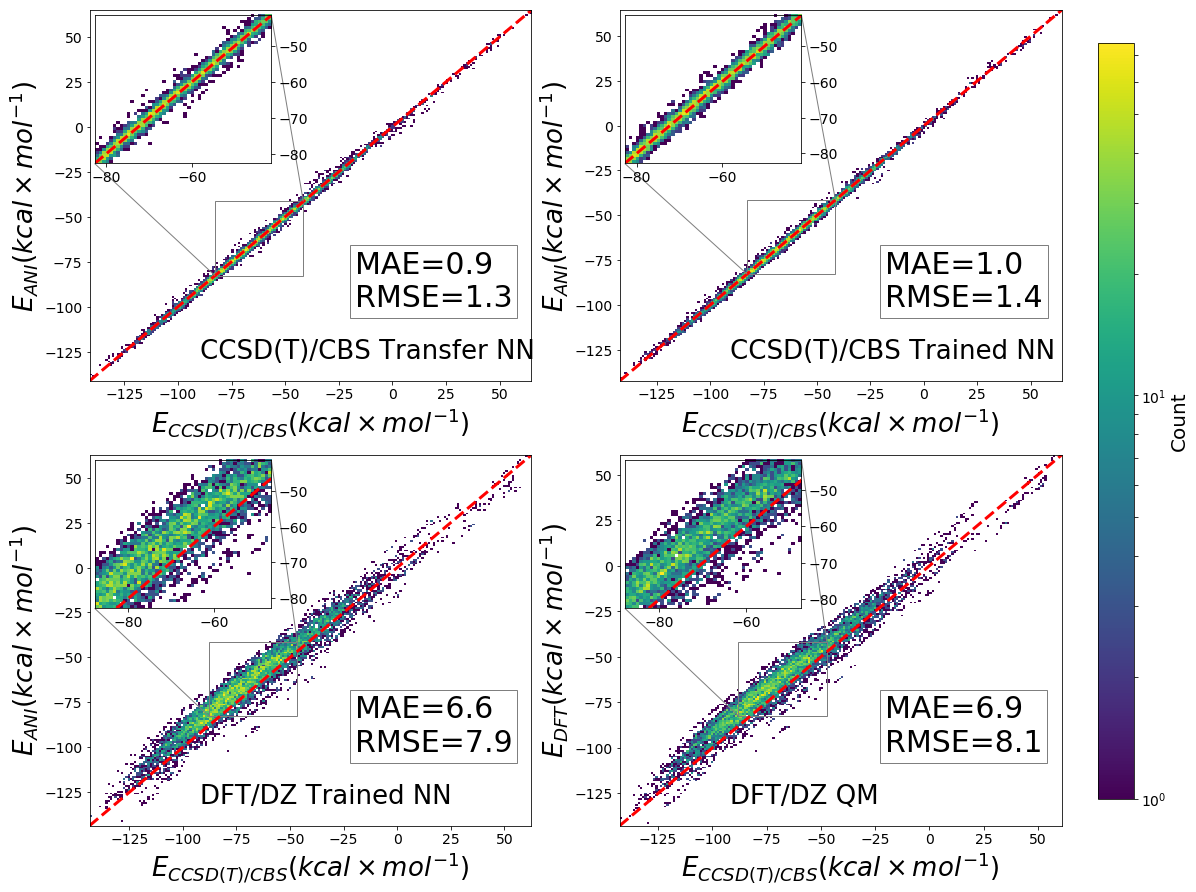

In [11]:
f = plt.subplots(figsize=[20,15])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.85, .85])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

bin1 = aes.plot_corr_dist_axes(ax1,Eal[0,:],Eal[1,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,Eal[0,:],Eal[2,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,Eal[0,:],Eal[3,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ Trained NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,Eal[0,:],Eal[4,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{DFT} (kcal \times mol^{-1})$',plabel='DFT/DZ QM',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.825, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()

In [12]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(hdt.hatokcal*(Edl),hdt.hatokcal*(Eal2))
#print(r_value**2)

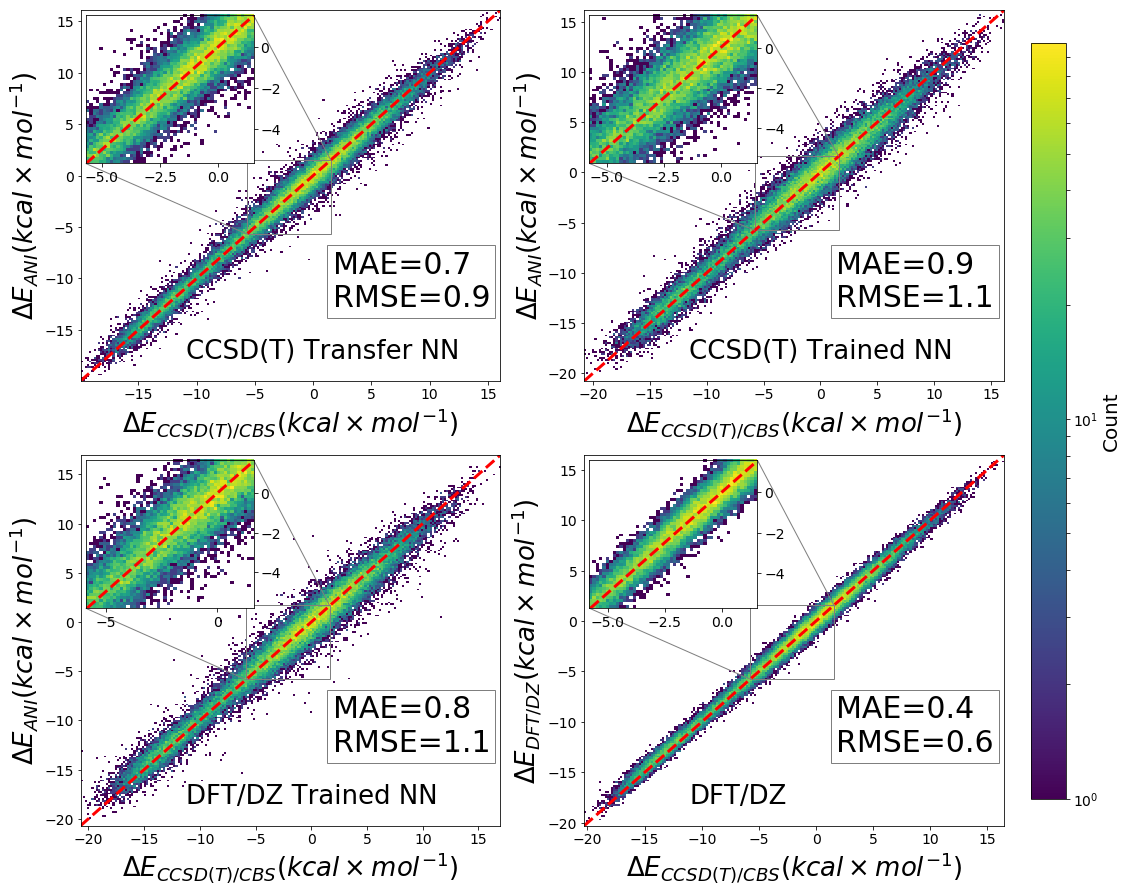

In [13]:
f = plt.subplots(figsize=[19,15])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.85, .85])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

bin1 = aes.plot_corr_dist_axes(ax1,dEal[0,:],dEal[1,:],labelx=r'$\Delta E_{CCSD(T)/CBS}(kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,dEal[0,:],dEal[2,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,dEal[0,:],dEal[3,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ Trained NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,dEal[0,:],dEal[4,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{DFT/DZ} (kcal \times mol^{-1})$',plabel='DFT/DZ',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.82, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin4[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()

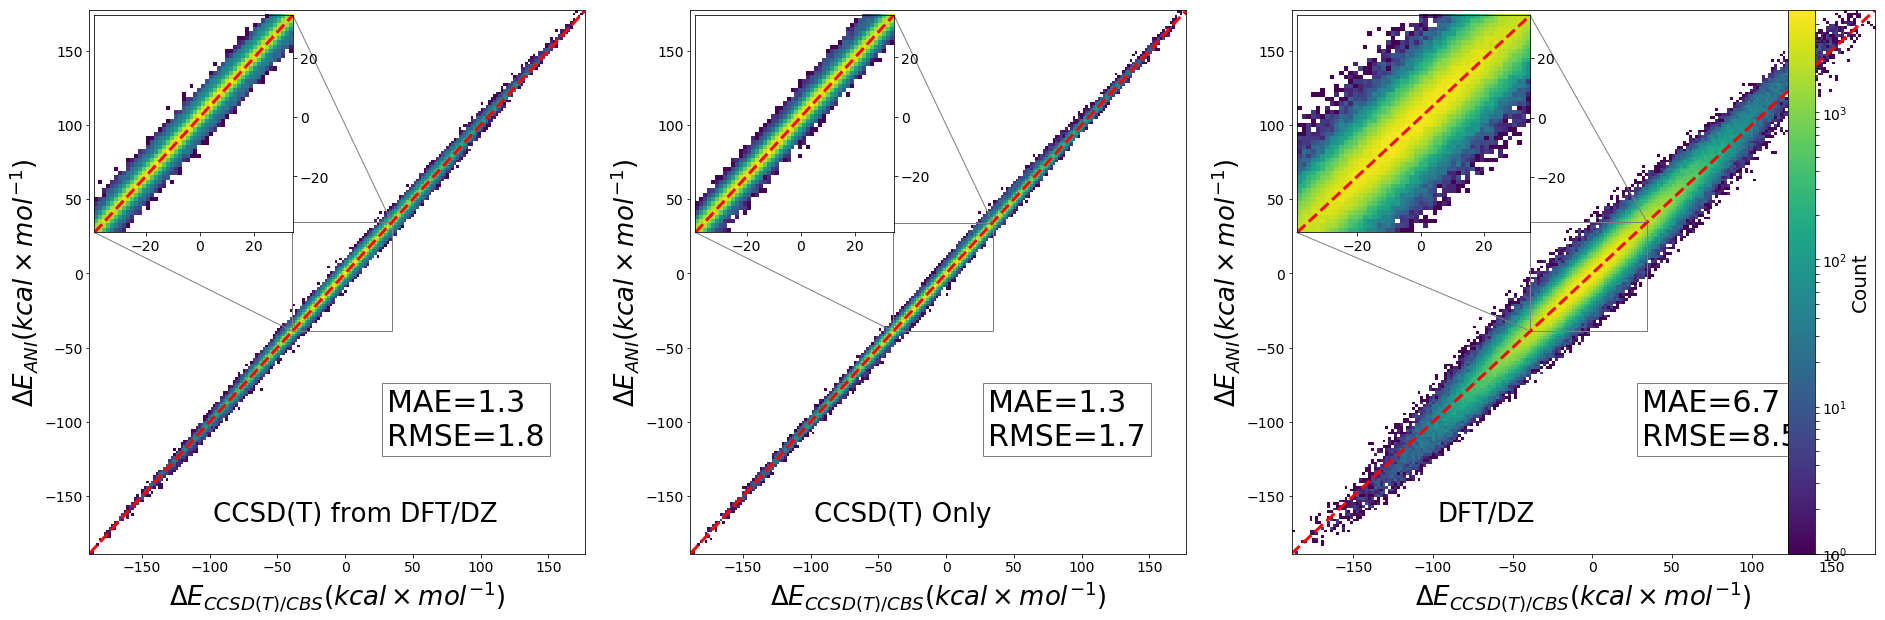

In [14]:
f = plt.subplots(figsize=[32,10])
gs  = gridspec.GridSpec(1, 3, width_ratios=[.85, .85, 1.0])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

Emin_ref = hdt.calculatedmat(Emin[:,0])

bin1 = aes.plot_corr_dist_axes(ax1,hdt.calculatedmat(Emin[:,1]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS}(kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) from DFT/DZ',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,hdt.calculatedmat(Emin[:,2]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Only',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,hdt.calculatedmat(Emin[:,3]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ',cmap=mpl.cm.viridis)
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis)
cb1.set_label('Count', fontsize=20)
plt.show()

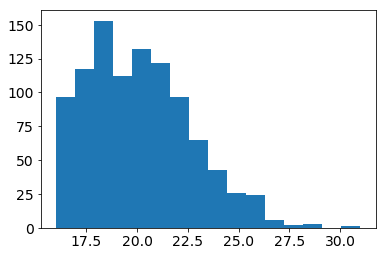

In [15]:
plt.hist(Na, bins=16)
plt.show()

In [16]:
f = plt.subplots(figsize=[24,10])
gs  = gridspec.GridSpec(1, 2, width_ratios=[.85, 1.0])
ax1 = plt.subplot(gs[0])

ax1.hist(dEdl-dEal1,bins=75, range=[-10,10], edgecolor='black', linewidth=1.2, ls='dashed', fc=(0, 0, 1, 0.4),label='Layer 1 and 3 frozen')
ax1.hist(dEdl-dEal2,bins=75, range=[-10,10], edgecolor='black', linewidth=1.2, ls='dashed', fc=(1, 0, 0, 0.4),label='Full model retrained')
ax1.set_title('Error Distributions', fontsize=24)
ax1.legend(fontsize=16)
ax1.set_xlabel(r'$\Delta E$ ($kcal \times mol^{-1}$)',fontsize=20)
ax1.set_ylabel('Count',fontsize=20)

ax2 = plt.subplot(gs[1])
ax2.hist(Na,bins=16, ls='dashed', edgecolor='black', linewidth=1.2, fc=(1, 0, 0, 0.4))
ax2.set_title('System sizes', fontsize=24)
ax2.set_xlabel('Numer of atoms',fontsize=20)

plt.show()

NameError: name 'dEdl' is not defined

In [17]:
adl = pyt.anidataloader('/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/s66x8_wb97x6-31gd.h5')

In [18]:
sdir = '/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/xyz_splits/'

/s66x8/mol00
[-95862.73161268] [-95862.8883302] [-95868.8575039]


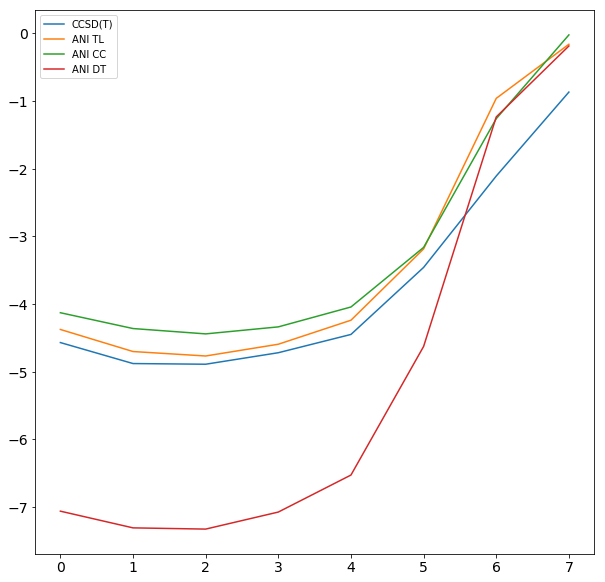

/s66x8/mol01
[-120486.05534732] [-120486.61875843] [-120524.74529214]


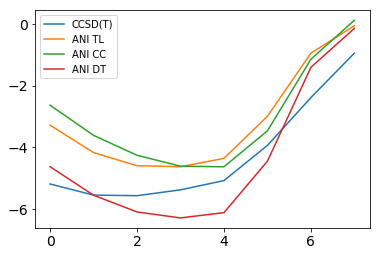

/s66x8/mol02
[-108020.49783279] [-108020.86538869] [-108064.153602]


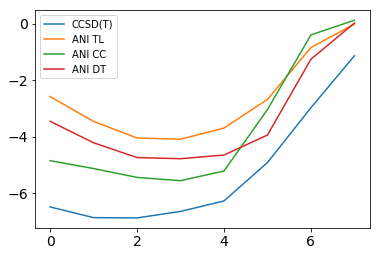

/s66x8/mol03
[-203722.73554482] [-203722.62222812] [-203843.72159437]


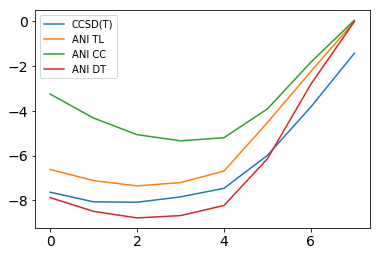

/s66x8/mol04
[-145109.3352594] [-145110.27080147] [-145180.71373185]


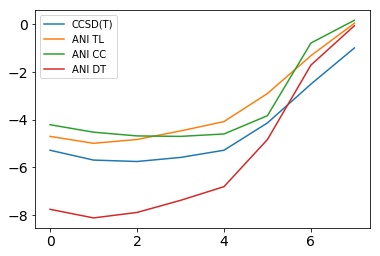

/s66x8/mol05
[-132643.68736044] [-132644.42354472] [-132720.05215269]


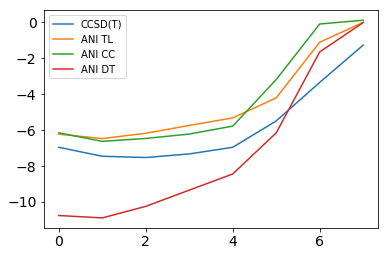

/s66x8/mol06
[-228345.68506803] [-228346.44500584] [-228499.30023264]


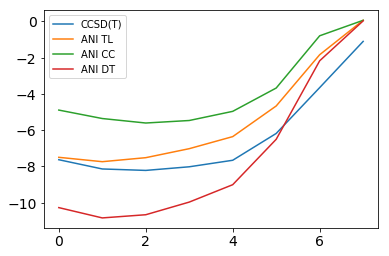

/s66x8/mol07
[-120486.01778244] [-120486.54233585] [-120524.82965907]


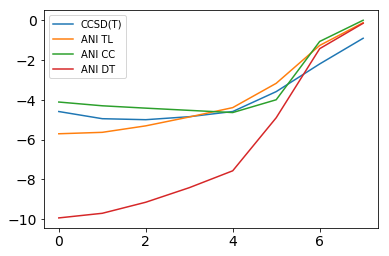

/s66x8/mol08
[-132643.90351163] [-132644.68510537] [-132720.18320702]


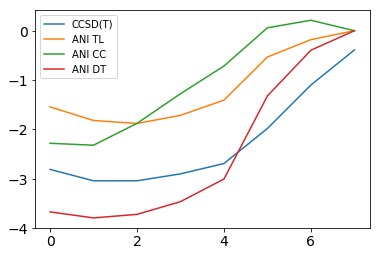

/s66x8/mol09
[-120178.39207691] [-120178.97747951] [-120259.56581564]


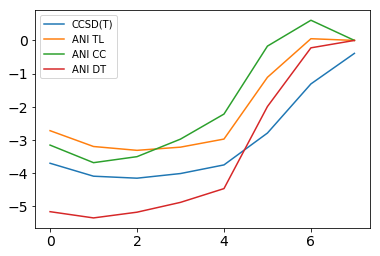

/s66x8/mol10
[-215880.30719227] [-215880.95389359] [-216038.71554359]


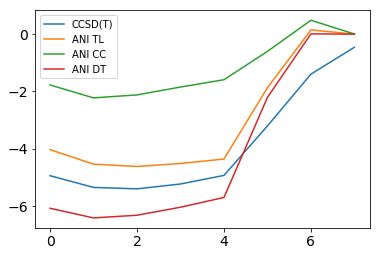

/s66x8/mol11
[-108020.49850732] [-108020.83505312] [-108064.13302445]


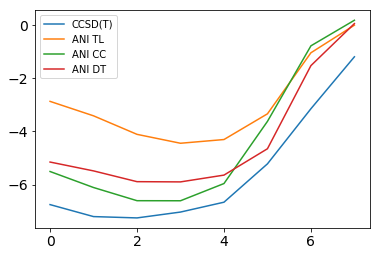

/s66x8/mol12
[-228345.90714063] [-228346.85843809] [-228499.30186312]


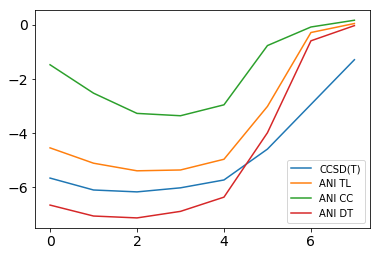

/s66x8/mol13
[-215880.27165915] [-215881.07678434] [-216038.62367005]


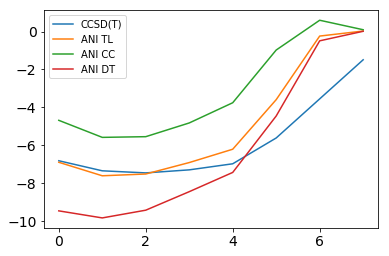

/s66x8/mol14
[-311582.8296032] [-311582.59781657] [-311818.65215617]


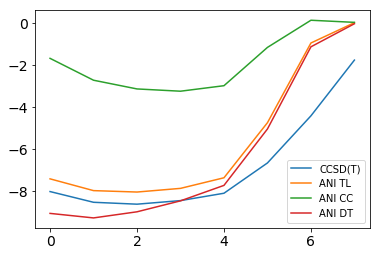

/s66x8/mol15
[-203722.81475175] [-203722.75006982] [-203843.77507705]


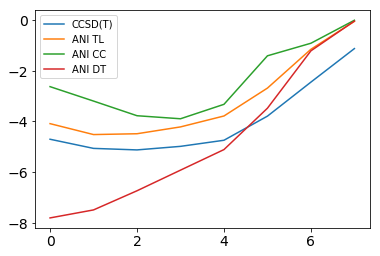

/s66x8/mol16
[-520093.66565558] [-520094.77605755] [-520477.68104086]


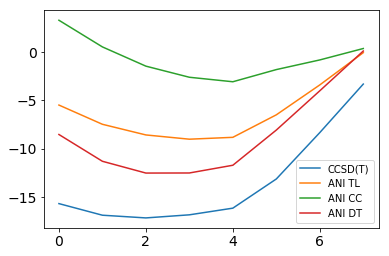

/s66x8/mol17
[-203534.93232409] [-203535.16701243] [-203689.72259456]


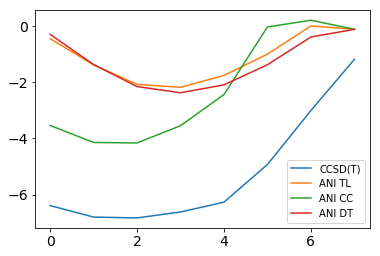

/s66x8/mol18
[-228158.11463687] [-228158.72501371] [-228345.6098318]


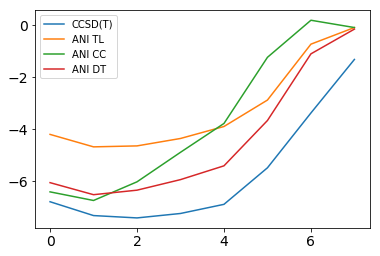

/s66x8/mol19
[-287255.08185453] [-287254.87595144] [-287428.5604726]


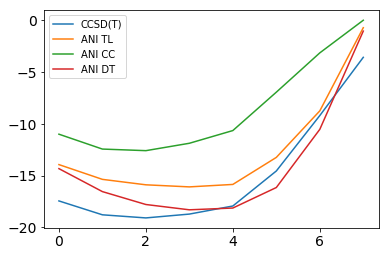

/s66x8/mol20
[-262316.04916329] [-262317.01347845] [-262494.96614042]


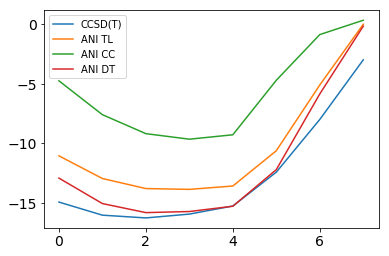

/s66x8/mol21
[-403674.32940606] [-403674.71590976] [-403953.15104469]


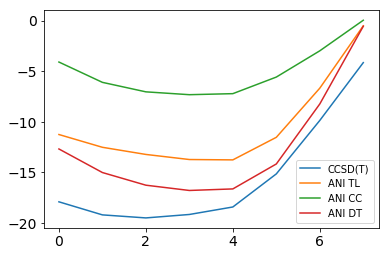

/s66x8/mol22
[-391204.74901474] [-391205.7618228] [-391486.28328946]


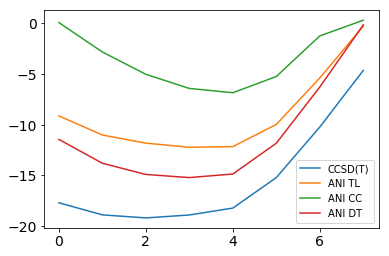

/s66x8/mol23
/s66x8/mol24
/s66x8/mol25
/s66x8/mol26
/s66x8/mol27
/s66x8/mol28
/s66x8/mol29
/s66x8/mol30
/s66x8/mol31
/s66x8/mol32
/s66x8/mol33
/s66x8/mol34
/s66x8/mol35
/s66x8/mol36
/s66x8/mol37
/s66x8/mol38
/s66x8/mol39
/s66x8/mol40
/s66x8/mol41
/s66x8/mol42
/s66x8/mol43
/s66x8/mol44
/s66x8/mol45
/s66x8/mol46
/s66x8/mol47
/s66x8/mol48
/s66x8/mol49
/s66x8/mol50
/s66x8/mol51
/s66x8/mol52
/s66x8/mol53
/s66x8/mol54
/s66x8/mol55
/s66x8/mol56
/s66x8/mol57
/s66x8/mol58
/s66x8/mol59
/s66x8/mol60
/s66x8/mol61
/s66x8/mol62
/s66x8/mol63
/s66x8/mol64
/s66x8/mol65


In [19]:
ccsd = open('/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/ccsd_t_energies.dat')
Es66 = []
for j,data in enumerate(adl):
    print(data['path'])
    
    if j < 23:

        Ecc = np.zeros(8,dtype=np.float64)
        for i in range(8):
            Ecc[i] = float(ccsd.readline().split()[-1])

        S = data['species']
        X = data['coordinates']
        Edft = hdt.hatokcal*data['energies']

        #print(Edft-Edft.min(),Ecc-Ecc.min())

        Ea1_t,Fa1_t,Sa1 = aens_1.compute_energyandforce_conformations(X,S)
        Ea2_t,Fa2_t,Sa2 = aens_2.compute_energyandforce_conformations(X,S)
        Ea3_t,Fa3_t,Sa3 = aens_3.compute_energyandforce_conformations(X,S)

        #print(os.listdir(sdir))
        
        X1,S1,Na1,C1 = hdt.readxyz2(sdir+'s66x8_'+str(j).zfill(2)+'-1.xyz')
        X2,S2,Na2,C2 = hdt.readxyz2(sdir+'s66x8_'+str(j).zfill(2)+'-2.xyz')
        
        
        Ea1s1_t,Fa1s1_t,Sas11 = aens_1.compute_energyandforce_conformations(X1,S1)
        Ea2s1_t,Fa2s1_t,Sas12 = aens_2.compute_energyandforce_conformations(X1,S1)
        Ea3s1_t,Fa3s1_t,Sas13 = aens_3.compute_energyandforce_conformations(X1,S1)

        Ea1s2_t,Fa1s2_t,Sas21 = aens_1.compute_energyandforce_conformations(X2,S2)
        Ea2s2_t,Fa2s2_t,Sas22 = aens_2.compute_energyandforce_conformations(X2,S2)
        Ea3s2_t,Fa3s2_t,Sas23 = aens_3.compute_energyandforce_conformations(X2,S2)
        
        print(Ea1s1_t+Ea1s2_t,Ea2s1_t+Ea2s2_t,Ea3s1_t+Ea3s2_t)
        
        Ea1s = Ea1s1_t + Ea1s2_t
        Ea2s = Ea2s1_t + Ea2s2_t
        Ea3s = Ea3s1_t + Ea3s2_t
        
        #plt.plot(Edft,label='DFT/DZ')
        plt.plot(Ecc,label='CCSD(T)')
        plt.plot(Ea1_t-Ea1s,label='ANI TL')
        plt.plot(Ea2_t-Ea2s,label='ANI CC')
        plt.plot(Ea3_t-Ea3s,label='ANI DT')
        
        Es66.append(np.array([Ecc,Ea1_t-Ea1s,Ea2_t-Ea2s,Ea3_t-Ea3s,Edft-Edft.min()]))

        plt.legend()
        plt.show()
Es66 = np.hstack(Es66)

In [20]:
print('E error -- s66x8 hydrogen bonding error')
print('        MAE               RMSE')
rms = hdt.calculaterootmeansqrerror(Es66[1,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[1,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[2,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[2,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[3,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[3,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[4,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[4,:],Es66[0,:])
print(mae,rms)

E error -- s66x8 hydrogen bonding error
        MAE               RMSE
2.151030117800002 2.954063958180426
3.6362454328681855 5.3393723109236015
1.8590390239959944 2.3532726199436924
9.626830924795627 10.969465827008907


In [ ]:
f = plt.subplots(figsize=[20,15])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.85, .85])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

bin1 = aes.plot_corr_dist_axes(ax1,Es66[0,:],Es66[1,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,Es66[0,:],Es66[2,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,Es66[0,:],Es66[3,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ Trained NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,Es66[0,:],Es66[4,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{DFT} (kcal \times mol^{-1})$',plabel='DFT/DZ QM',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.825, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()